#### CONVERTING RAW CSV DATASET TO UNSTRUCTURED JSON DATA

In [267]:
import pandas as pd

# Load the CSV file into a DataFrame
df = pd.read_csv(r'C:/Users/neethu/Desktop/DAP/DataSet/nyscancer-region.csv')

# Convert DataFrame to JSON
json_data = df.to_json(orient='records')

# Save JSON data to a file
with open(r'C:/Users/neethu/Desktop/DAP/DataSet/nyscancer-region.json', 'w') as json_file:
    json_file.write(json_data)
    
print("converted from csv to unstructred json data")


converted from csv to unstructred json data


#### Connect and load raw data to MongoDB

In [268]:
import pandas as pd
import pymongo

# Load the DataFrame from the JSON file
df = pd.read_json(r'C:/Users/neethu/Desktop/DAP/DataSet/nyscancer-region.json')

# MongoDB connection settings
client = pymongo.MongoClient("mongodb://localhost:27017/")
db = client["Datas"]
collection = db["Cancer Data"]

# Drop existing records in the collection
collection.delete_many({})

# Convert DataFrame to dictionary
records = df.to_dict(orient='records')

# Insert records into MongoDB collection
collection.insert_many(records)

# Load data from MongoDB into a DataFrame
cursor = collection.find({})
df_from_mongo = pd.DataFrame(list(cursor))
original_count=collection.count_documents({})

print("Data written successfully to MongoDB")
print("Number of raw data : ",original_count)

Data written successfully to MongoDB
Number of raw data :  22968


#### Extracting from MongoDB

In [269]:
import pandas as pd
import pymongo
import psycopg2
import matplotlib.pyplot as plt

# Extract data from MongoDB (Extract step)

cursor = collection.find({})
df_from_mongo = pd.DataFrame(list(cursor))

# Drop existing records in the collection
collection.delete_many({})

print("Number of raw data :", len(df_from_mongo))

Number of raw data : 22968


#### Transform data to eliminate invalid values

In [270]:
# Load the DataFrame from MongoDB and drop NaN values in specified columns (Transform step)
columns_to_clean = ['OLUNG', 'LATITUDE', 'LONGITUDE']
df_cleaned = df_from_mongo.dropna(subset=columns_to_clean, how='any')

print("Count after Transform step 1 (dropping NaN/Null values):", len(df_cleaned))

# Convert columns to string type to handle non-numeric values
df_cleaned.loc[:, 'OLUNG'] = df_cleaned['OLUNG'].astype(str)
df_cleaned.loc[:, 'LATITUDE'] = df_cleaned['LATITUDE'].astype(str)
df_cleaned.loc[:, 'LONGITUDE'] = df_cleaned['LONGITUDE'].astype(str)

# Convert columns to string
#df_cleaned['OLUNG'] = df_cleaned['OLUNG'].astype(str)
#df_cleaned['LATITUDE'] = df_cleaned['LATITUDE'].astype(str)
#df_cleaned['LONGITUDE'] = df_cleaned['LONGITUDE'].astype(str)

# Clean rows where 'OLUNG', 'LATITUDE', and 'LONGITUDE' values are non-numeric
df_cleaned = df_cleaned[df_cleaned['OLUNG'].str.match(r'^\d*\.?\d+$')]
df_cleaned = df_cleaned[df_cleaned['LATITUDE'].str.match(r'^-?\d*\.?\d+$')]
df_cleaned = df_cleaned[df_cleaned['LONGITUDE'].str.match(r'^-?\d*\.?\d+$')]

print("Count after Transform step 2 (cleaning non-numeric values):", len(df_cleaned))
df_cleaned


Count after Transform step 1 (dropping NaN/Null values): 22967
Count after Transform step 2 (cleaning non-numeric values): 22966


,_id,"DOHREGION,C,12",LATITUDE,LONGITUDE,OLUNG,HLUNG,"YEAR,C,4"
2,663283bb91e04c4b20984caa,3.60E+11,40.63123016,-73.98176104,30,1,2009
3,663283bb91e04c4b20984cab,3.60E+11,40.57810189,-74.00844422,23,1,2009
4,663283bb91e04c4b20984cac,3.60E+11,40.57753787,-73.99691861,24,0,2009
5,663283bb91e04c4b20984cad,3.60E+11,40.60901652,-74.01456365,30,1,2009
6,663283bb91e04c4b20984cae,3.60E+11,40.58537192,-74.01956116,35,1,2009
...,...,...,...,...,...,...,...
22963,663283bb91e04c4b2098a65b,3.61E+11,40.6425001,-74.08126414,39,0,2009
22964,663283bb91e04c4b2098a65c,3.61E+11,40.87572184,-74.25077886,10,0,2009
22965,663283bb91e04c4b2098a65d,3.61E+11,40.61390255,-74.08764228,31,0,2009
22966,663283bb91e04c4b2098a65e,3.61E+11,40.83929014,-74.20804481,14,0,2009


#### Connecting to postgre and assigning valid regions(within New York City) based on dataset 1

In [271]:
conn = psycopg2.connect(dbname=dbname, user=user, password=password, host=host, port=port)
cur = conn.cursor()

# Define function to assign regions based on latitude and longitude
def assign_region(latitude, longitude):
    cur.execute("SELECT region FROM region_boundaries WHERE %s BETWEEN min_latitude AND max_latitude AND %s BETWEEN min_longitude AND max_longitude", (latitude, longitude))
    result = cur.fetchone()
    if result:
        return result[0]
    else:
        return 'Other Cities'

# Apply the function to assign regions
df_cleaned['REGION'] = df_cleaned.apply(lambda row: assign_region(float(row['LATITUDE']), float(row['LONGITUDE'])), axis=1)

# Print distinct regions of df_cleaned at the end
distinct_regions = df_cleaned['REGION'].unique()
print("Distinct regions of df_cleaned:", distinct_regions)

print("done")

Distinct regions of df_cleaned: ['Brooklyn Southwest' 'Queens Northeast' 'Brooklyn East' 'Bronx North'
 'Manhattan Central' 'Manhattan South' 'Bronx South Central' 'Queens West'
 'Queens South' 'New York City Centre' 'Staten Island' 'Other Cities']
done


#### Transform and load relevant datas to Postgre

In [272]:
# Define a new DataFrame with only necessary columns for PostgreSQL insertion
df_postgre = df_cleaned[df_cleaned['REGION'] != 'Other Cities'][['REGION', 'OLUNG']]

# Load data into PostgreSQL (Load step)
conn = psycopg2.connect(dbname=dbname, user=user, password=password, host=host, port=port)
cur = conn.cursor()

# Drop existing PostgreSQL table if it exists
cur.execute("DROP TABLE IF EXISTS cancerdata;")

# Create table to store transformed data
cur.execute('''
    CREATE TABLE IF NOT EXISTS cancerdata (
        region VARCHAR(50),
        total_olung INTEGER
    )
''')

print("Count before Load step:", len(df_postgre))

# Load data into PostgreSQL
for index, row in df_postgre.iterrows():
    cur.execute('''
        INSERT INTO cancerdata (region, total_olung)
        VALUES (%s, %s)
    ''', (row['REGION'], int(row['OLUNG'])))

# Commit changes
conn.commit()
conn.close()

print("Data loaded into PostgreSQL successfully.")


Count before Load step: 22295
Data loaded into PostgreSQL successfully.


#### Plotting data as bar graph for visualisation

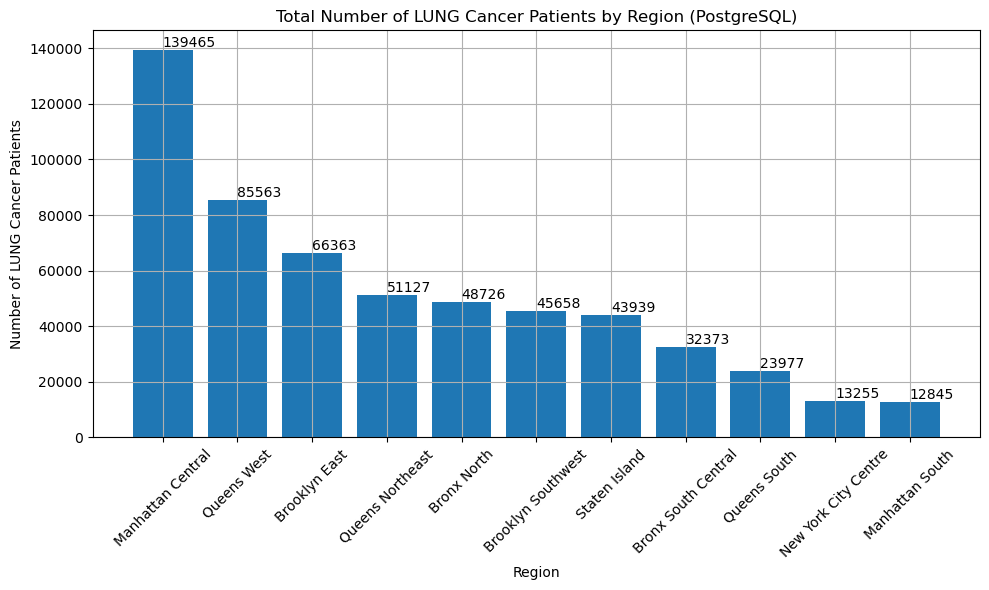

In [273]:
# Plot the data after loading into PostgreSQL (Load step)
conn = psycopg2.connect(dbname=dbname, user=user, password=password, host=host, port=port)
cur = conn.cursor()

# Retrieve data from PostgreSQL
cur.execute('''
    SELECT region, SUM(total_olung) as total_olung
    FROM cancerdata
    GROUP BY region
    ORDER BY total_olung DESC
''')
rows = cur.fetchall()

# Create a DataFrame from retrieved data
df_postgre_plot = pd.DataFrame(rows, columns=['REGION', 'Total_OLUNG'])

# Plot the bar graph
plt.figure(figsize=(10,6))
bars = plt.bar(df_postgre_plot['REGION'], df_postgre_plot['Total_OLUNG'])

# Annotate each bar with its value
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), va='bottom')

plt.title('Total Number of LUNG Cancer Patients by Region (PostgreSQL)')
plt.xlabel('Region')
plt.ylabel('Number of LUNG Cancer Patients')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(True)
plt.tight_layout()

# Save the plot as an image
plt.savefig('lung_cancer_patients_by_region_postgresql.png')

# Display the plot
plt.show()

# Close the PostgreSQL connection
conn.close()
